In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp

import holodeck as holo
import holodeck.single_sources as ss
import holodeck.detstats as det
from holodeck.constants import YR, MSOL
from holodeck import utils


import hasasia.sensitivity as hsen
import hasasia.sim as hsim

# Build SAM and calculate strains

Make the semi-analytic model object.

In [2]:
# dur = 10.0*YR
# cad = 0.2*YR
# fobs = utils.nyquist_freqs(dur,cad)
# fobs_edges = utils.nyquist_freqs_edges(dur,cad)
# sam = holo.sam.Semi_Analytic_Model() 
# # sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
# hard = holo.hardening.Hard_GW
# fobs_orb_edges = fobs_edges / 2.0 
# fobs_orb_cents = fobs/ 2.0
# # edges
# edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
# edges[-1] = fobs_orb_edges
# dfobs = np.diff(edges[-1])
# # integrate for number
# number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
# number = number * np.diff(np.log(fobs_edges)) 
# hc_ss, hc_bg = ss.ss_gws(edges, number, realize=1, 
#                                         loudest = 1, params = False) 
# np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/sample_sam_A.npz', 
#          dur=dur, cad=cad, fobs=fobs, dfobs=dfobs, hc_ss=hc_ss, hc_bg=hc_bg)

In [3]:
hcfile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/sample_sam_A.npz')
dur = hcfile['dur']
cad = hcfile['cad']
fobs = hcfile['fobs']
dfobs = hcfile['dfobs']
hc_ss = hcfile['hc_ss']
hc_bg = hcfile['hc_bg']

# Set Up 1 SS


Place the single sources randomly across the sky
Isolate the 5th frequency bin source, place it.

In [4]:
# theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# psi_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape) 
# Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss.size).reshape(hc_ss.shape)
# np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/random_binary_angles_B.npz',
#          theta_ss=theta_ss, phi_ss=phi_ss, iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
infile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/random_binary_angles_B.npz')
theta_ss = infile['theta_ss']
phi_ss = infile['phi_ss']
iota_ss = infile['iota_ss']
psi_ss = infile['psi_ss']
Phi0_ss = infile['Phi0_ss']

test=np.ones(theta_ss.shape)
# # special 5th bin:
ss=4
def reset_ss():
    theta_ss[ss,0,0] = np.pi/8
    phi_ss[ss,0,0] = np.pi/8
    iota_ss[ss,0,0] = 0
    psi_ss[ss,0,0] = np.pi/2
    Phi0_ss[ss,0,0] = 0
    hc_ss = np.zeros(theta_ss.shape)
    hc_ss[ss,0,0] = 5e-15
    return theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()

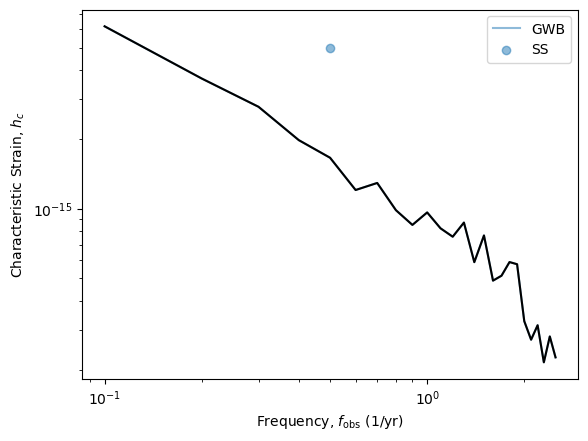

In [5]:
def plot_hc():
    nreals = np.min([10, len(hc_bg[0])])
    colors = cm.rainbow(np.linspace(0,1,nreals))
    plt.xlabel('Frequency, $f_\mathrm{obs}$ (1/yr)')
    plt.ylabel('Characteristic Strain, $h_c$')
    for rr in range(nreals):
        if(rr==0):
            label_bg = 'GWB'
            label_ss = 'SS'
        else:
            label_bg = None
            label_ss = None
        plt.loglog(fobs*YR, hc_bg[:,rr], alpha=0.5, label=label_bg)
        plt.scatter(fobs*YR, hc_ss[:,rr], alpha=0.5, label=label_ss)
    plt.loglog(fobs*YR, np.median(hc_bg, axis=1), color='k')
    plt.legend()

plot_hc()

# Set Up 2 Pulsars
* 2 pulsars
* 45 degrees ($\pi$/4) apart in $\phi$
* same $\theta=0$

In [6]:
# set pulsar parameters
def reset_pulsars(npsrs=2, phis = np.array([0,np.pi/4]), thetas = np.array([0,0]), 
    sigmas = np.array([1e-7,1e-7])):
    # build sim_pta
    pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                        phi=phis, theta=thetas)
    # get spectrum for each
    spectra = np.empty_like(pulsars, dtype=hsen.Spectrum)
    for ii in range(npsrs):
        spectra[ii] = hsen.Spectrum(pulsars[ii], freqs=fobs)
        spectra[ii].NcalInv # calculate inverse noise weighted transmission function
    # get sensitivity curve
    scDeter = hsen.DeterSensitivityCurve(list(spectra))
    return npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

And it's deterministic sensitivity curve.

Detection probability by 3 methods:
* det = detect_ss() uses the stored arrays with Rosado equations
* pta = detect_ss_pta() uses the pulsar list object with Rosado equations
* has = detect_ss_scDeter() uses the hasasia.DeterSensitivityCurve SNR's to calculate dp

In [7]:
dp_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_pta, snr_pta = det.detect_ss_pta(pulsars, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_pta, snr_pta.shape, snr_pta.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())


gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
[0.00033395] (25, 1, 1) [0.        0.        0.  

TypeError: detect_ss_scDeter() missing 2 required positional arguments: 'dfobs' and 'hc_ss'

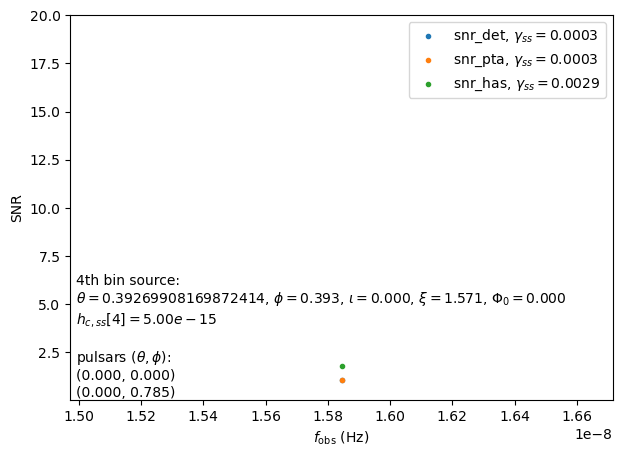

In [ ]:
def plot_snr():
        fig,ax = plt.subplots(figsize=(7,5))
        ax.scatter(fobs[ss], snr_det.squeeze()[ss], label='snr_det, $\gamma_{ss}=%.4f$' % dp_det, marker='.')
        ax.scatter(fobs[ss], snr_pta.squeeze()[ss], label='snr_pta, $\gamma_{ss}=%.4f$' % dp_pta, marker='.') # should be exact same, check!
        ax.scatter(fobs[ss], snr_has.squeeze()[ss], label='snr_has, $\gamma_{ss}=%.4f$' % dp_has, marker='.')

        # ax.scatter(fobs[ss], snr_det.squeeze()[ss], color='red', )
        # ax.scatter(fobs[ss], snr_pta.squeeze()[ss], color='k')
        # ax.scatter(fobs[ss], snr_has.squeeze()[ss], color='k')
        ax.set_ylim(1e-5,2e1)
        ax.set_xlabel('$f_\mathrm{obs}$ (Hz)')
        ax.set_ylabel('SNR')

        ax.legend(loc='upper right')
        ax.text(.01, .01, r'pulsars $(\theta, \phi)$:'+'\n(%.3f, %.3f) \n(%.3f, %.3f)'
                %(thetas[0], phis[0], thetas[1], phis[1]), 
                transform=ax.transAxes)
        ax.text(.01, .2, ('%dth bin source:\n' %ss + r'$\theta=$'+str(theta_ss.squeeze()[ss]) 
                        + r', $\phi=$'+'%.3f'% (phi_ss.squeeze()[ss]) 
                        + r', $\iota=$'+'%.3f'% (iota_ss.squeeze()[ss])
                        + r', $\psi=$'+'%.3f'% (psi_ss.squeeze()[ss]) 
                        + r', $\Phi_0=$'+'%.3f'% (Phi0_ss.squeeze()[ss]) 
                        + '\n$h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                        ), 
                transform=ax.transAxes)
plot_snr()

# 1.. Isolate Strain
double it

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
hc_arr = np.geomspace(.001, 100, 100)
SNR_det_of_hc = np.zeros(hc_arr.shape)
DP_det_of_hc = np.zeros(hc_arr.shape)
SNR_has_of_hc = np.zeros(hc_arr.shape)
DP_has_of_hc = np.zeros(hc_arr.shape)
for ii in range(num):
    DP_det_of_hc[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_arr[ii]*hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_hc[ii] = temp_det[ss]
    DP_has_of_hc[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, 
                                                                hc_arr[ii]*hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_hc[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[

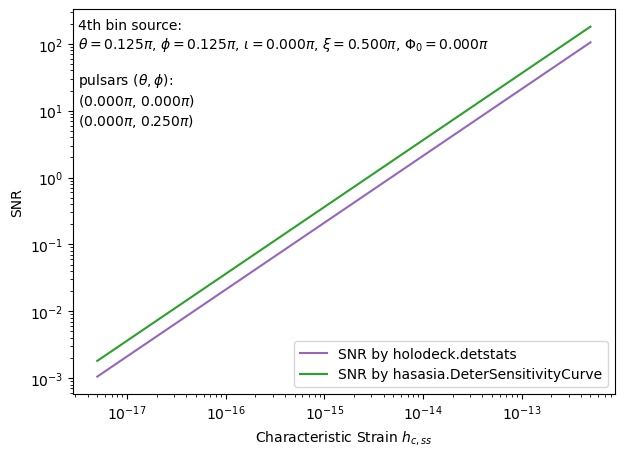

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('Characteristic Strain $h_{c,ss}$')
ax.set_ylabel('SNR')
ax.loglog(hc_arr*hc_ss[ss,0,0], SNR_det_of_hc, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(hc_arr*hc_ss[ss,0,0], SNR_has_of_hc, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$) \n(%.3f$\pi$, %.3f$\pi$)'
                %(thetas[0]/np.pi, phis[0]/np.pi, thetas[1]/np.pi, phis[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                  + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                  + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                  + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                  + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                #   + '\n$h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')

# 2.. Isolate $\theta$

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
theta_arr = np.linspace(0, np.pi, num)
SNR_det_of_theta = np.zeros(hc_arr.shape)
DP_det_of_theta = np.zeros(hc_arr.shape)
SNR_has_of_theta = np.zeros(hc_arr.shape)
DP_has_of_theta = np.zeros(hc_arr.shape)
for ii in range(num):
    theta_ss[ss] = theta_arr[ii]
    DP_det_of_theta[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_theta[ii] = temp_det[ss]
    DP_has_of_theta[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_theta[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[4,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[

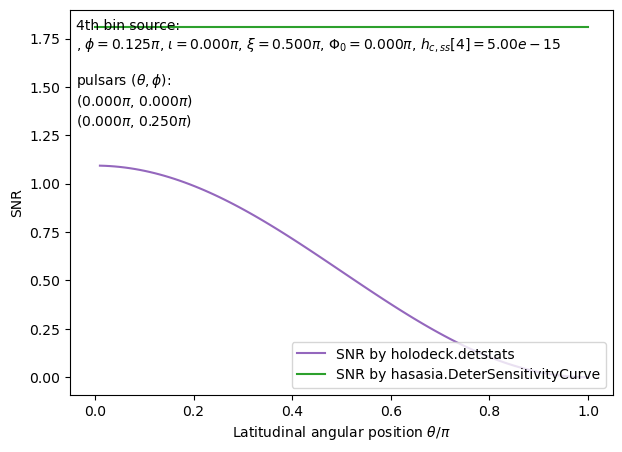

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'Latitudinal angular position $\theta / \pi$')
ax.set_ylabel('SNR')
ax.plot(theta_arr/np.pi, SNR_det_of_theta, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(theta_arr/np.pi, SNR_has_of_theta, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$) \n(%.3f$\pi$, %.3f$\pi$)'
                %(thetas[0]/np.pi, phis[0]/np.pi, thetas[1]/np.pi, phis[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                #   + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                  + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                  + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                  + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                  + ', $h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')

Highest when closest to pulsars, nice.

# 3.. Isolate $\phi$

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
phi_arr = np.linspace(0, 2*np.pi, num)
SNR_det_of_phi = np.zeros(hc_arr.shape)
DP_det_of_phi = np.zeros(hc_arr.shape)
SNR_has_of_phi = np.zeros(hc_arr.shape)
DP_has_of_phi = np.zeros(hc_arr.shape)
for ii in range(num):
    phi_ss[ss] = phi_arr[ii]
    DP_det_of_phi[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_phi[ii] = temp_det[ss]
    DP_has_of_phi[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_phi[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[

(0.5, 2.5)

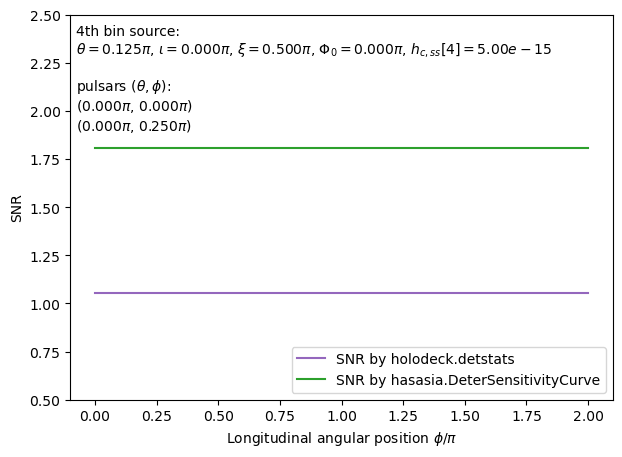

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'Longitudinal angular position $\phi / \pi$')
ax.set_ylabel('SNR')
ax.plot(phi_arr/np.pi, SNR_det_of_phi, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(phi_arr/np.pi, SNR_has_of_phi, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$) \n(%.3f$\pi$, %.3f$\pi$)'
                %(thetas[0]/np.pi, phis[0]/np.pi, thetas[1]/np.pi, phis[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                  + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                #   + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                  + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                  + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                  + ', $h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')
ax.set_ylim(0.5, 2.5)

Why doesn't either depend on phi? 

# 4.. Isolate Polarization $\psi$

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
psi_arr = np.linspace(0, np.pi, num)
SNR_det_of_psi = np.zeros(hc_arr.shape)
DP_det_of_psi = np.zeros(hc_arr.shape)
SNR_has_of_psi = np.zeros(hc_arr.shape)
DP_has_of_psi = np.zeros(hc_arr.shape)
for ii in range(num):
    psi_ss[ss] = psi_arr[ii]
    DP_det_of_psi[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_psi[ii] = temp_det[ss]
    DP_has_of_psi[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_psi[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[

(0.5, 2.5)

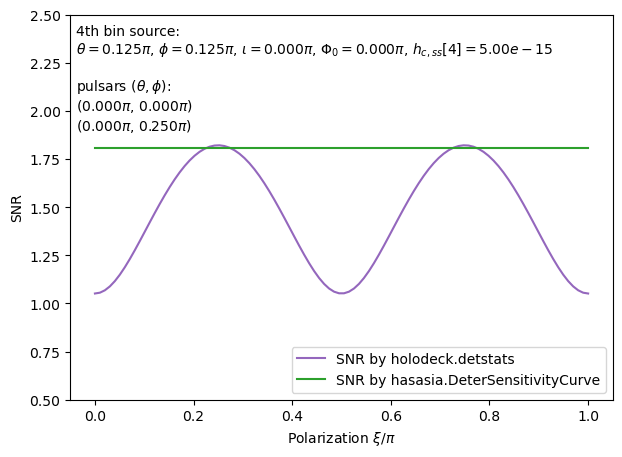

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'Polarization $\psi / \pi$')
ax.set_ylabel('SNR')
ax.plot(psi_arr/np.pi, SNR_det_of_psi, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(psi_arr/np.pi, SNR_has_of_psi, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$) \n(%.3f$\pi$, %.3f$\pi$)'
                %(thetas[0]/np.pi, phis[0]/np.pi, thetas[1]/np.pi, phis[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                  + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                  + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                  + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                #   + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                  + ', $h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')
ax.set_ylim(0.5, 2.5)

In [ ]:
print(psi_arr[np.argmax(SNR_det_of_psi)]/np.pi)

0.7474747474747475


# 5.. Isolate Inclination $\iota$

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
iota_arr = np.linspace(0, np.pi, num)
SNR_det_of_iota = np.zeros(hc_arr.shape)
DP_det_of_iota = np.zeros(hc_arr.shape)
SNR_has_of_iota = np.zeros(hc_arr.shape)
DP_has_of_iota = np.zeros(hc_arr.shape)
for ii in range(num):
    iota_ss[ss] = iota_arr[ii]
    DP_det_of_iota[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_iota[ii] = temp_det[ss]
    DP_has_of_iota[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_iota[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[

(0.0, 2.5)

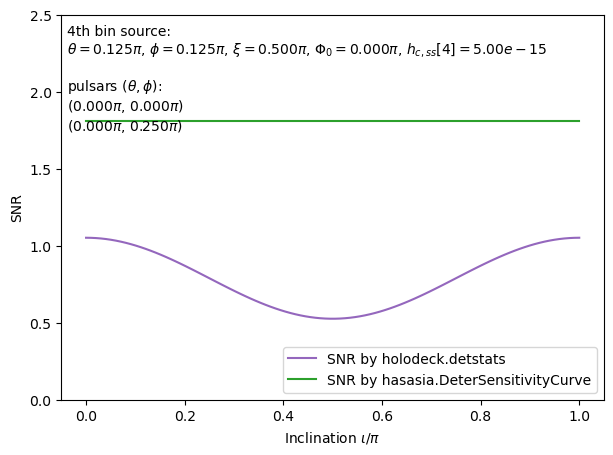

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'Inclination $\iota / \pi$')
ax.set_ylabel('SNR')
ax.plot(iota_arr/np.pi, SNR_det_of_iota, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(iota_arr/np.pi, SNR_has_of_iota, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$) \n(%.3f$\pi$, %.3f$\pi$)'
                %(thetas[0]/np.pi, phis[0]/np.pi, thetas[1]/np.pi, phis[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                  + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                  + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                #   + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                  + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                  + ', $h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')
ax.set_ylim(0, 2.5)

# 6.. Move One Pulsar

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
pphi_arr = np.linspace(0, 2*np.pi, num)
SNR_det_of_pphi = np.zeros(hc_arr.shape)
DP_det_of_pphi = np.zeros(hc_arr.shape)
SNR_has_of_pphi = np.zeros(hc_arr.shape)
DP_has_of_pphi = np.zeros(hc_arr.shape)
for ii in range(num):
    phis[1] = pphi_arr[ii]
    npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars(phis=phis)
    DP_det_of_pphi[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_pphi[ii] = temp_det[ss]
    DP_has_of_pphi[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_pphi[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[

(0.5, 2.5)

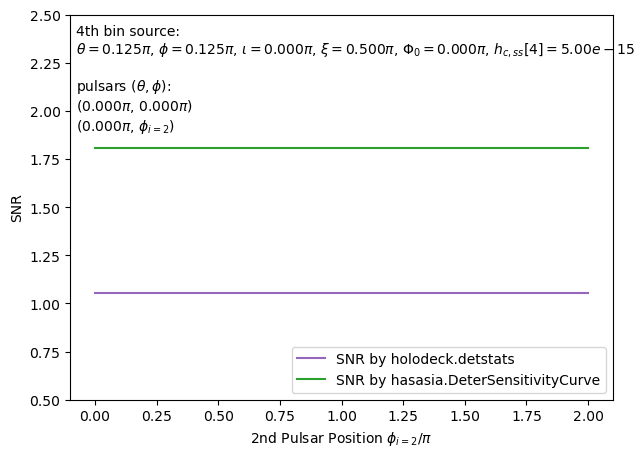

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'2nd Pulsar Position $\phi_{i=2} / \pi$')
ax.set_ylabel('SNR')
ax.plot(pphi_arr/np.pi, SNR_det_of_pphi, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(pphi_arr/np.pi, SNR_has_of_pphi, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$) \n(%.3f$\pi$, $\phi_{i=2}$)'
                %(thetas[0]/np.pi, phis[0]/np.pi, thetas[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                  + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                  + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                  + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                  + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                  + ', $h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')
ax.set_ylim(0.5, 2.5)

# 7.. Move One Pulsar Theta

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
ptheta_arr = np.linspace(0, np.pi, num)
SNR_det_of_ptheta = np.zeros(hc_arr.shape)
DP_det_of_ptheta = np.zeros(hc_arr.shape)
SNR_has_of_ptheta = np.zeros(hc_arr.shape)
DP_has_of_ptheta = np.zeros(hc_arr.shape)
for ii in range(num):
    thetas[1] = ptheta_arr[ii]
    npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars(thetas=thetas)
    DP_det_of_ptheta[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_ptheta[ii] = temp_det[ss]
    DP_has_of_ptheta[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_ptheta[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[

(0.5, 2.5)

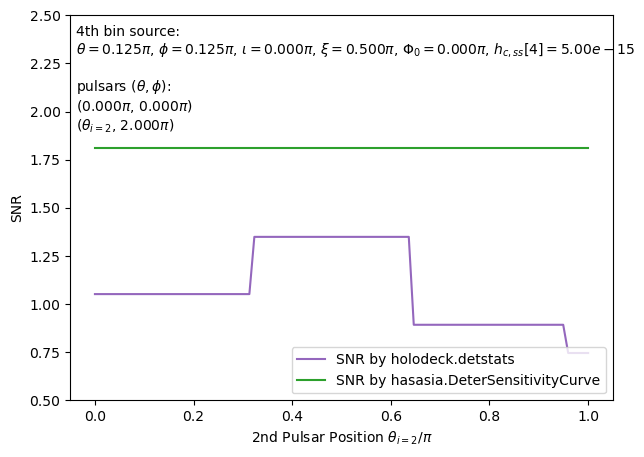

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'2nd Pulsar Position $\theta_{i=2} / \pi$')
ax.set_ylabel('SNR')
ax.plot(ptheta_arr/np.pi, SNR_det_of_ptheta, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(ptheta_arr/np.pi, SNR_has_of_ptheta, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$)'%(thetas[0]/np.pi, phis[0]/np.pi)        
        +' \n('+r'$\theta_{i=2}$,'+' %.3f$\pi$)' % (phis[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                  + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                  + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                  + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                  + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                  + ', $h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')
ax.set_ylim(0.5, 2.5)

# 8.. Change pulsar noise

In [ ]:
theta_ss, phi_ss, iota_ss, psi_ss, Phi0_ss, hc_ss = reset_ss()
npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars()

num = 100
psigma_arr = np.geomspace(1e-10, 1e-3, num)
SNR_det_of_psigma = np.zeros(hc_arr.shape)
DP_det_of_psigma = np.zeros(hc_arr.shape)
SNR_has_of_psigma = np.zeros(hc_arr.shape)
DP_has_of_psigma = np.zeros(hc_arr.shape)
for ii in range(num):
    sigmas = np.array([psigma_arr[ii], psigma_arr[ii]])
    npsrs, thetas, phis, sigmas, pulsars, spectra, scDeter = reset_pulsars(sigmas=sigmas)
    DP_det_of_psigma[ii], temp_det = det.detect_ss(thetas, phis, sigmas, cad, dur, 
                                                        fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_det_of_psigma[ii] = temp_det[ss]
    DP_has_of_psigma[ii], temp_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
    SNR_has_of_psigma[ii] = temp_has[ss]

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[

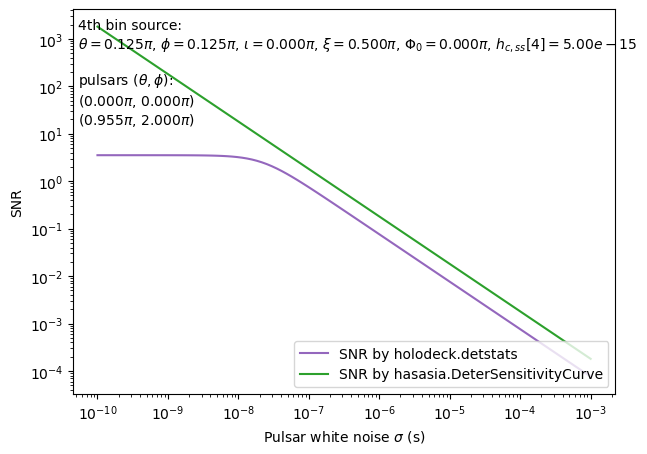

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel(r'Pulsar white noise $\sigma$ (s)')
ax.set_ylabel('SNR')
ax.loglog(psigma_arr, SNR_det_of_psigma, label='SNR by holodeck.detstats', color='tab:purple')
ax.plot(psigma_arr, SNR_has_of_psigma, label='SNR by hasasia.DeterSensitivityCurve', color='tab:green')
ax.text(.01, .7, r'pulsars $(\theta, \phi)$:'+'\n(%.3f$\pi$, %.3f$\pi$) \n(%.3f$\pi$, %.3f$\pi$)'
                %(thetas[0]/np.pi, phis[0]/np.pi, thetas[1]/np.pi, phis[1]/np.pi), 
                transform=ax.transAxes)
ax.text(.01, .9, ('%dth bin source:\n' %ss 
                  + r'$\theta=$'+'%.3f$\pi$'%(theta_ss.squeeze()[ss]/np.pi) 
                  + r', $\phi=$'+'%.3f$\pi$'% (phi_ss.squeeze()[ss]/np.pi) 
                  + r', $\iota=$'+'%.3f$\pi$'% (iota_ss.squeeze()[ss]/np.pi)
                  + r', $\psi=$'+'%.3f$\pi$'% (psi_ss.squeeze()[ss]/np.pi) 
                  + r', $\Phi_0=$'+'%.3f$\pi$'% (Phi0_ss.squeeze()[ss]/np.pi) 
                  + ', $h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                ), 
        transform=ax.transAxes)
ax.legend(loc='lower right')
# ax.set_ylim(0.5, 2.5)

# for sources at all frequencies

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
[4.00192132e-05] (25, 1, 1) [0.00000000e+00 0.000

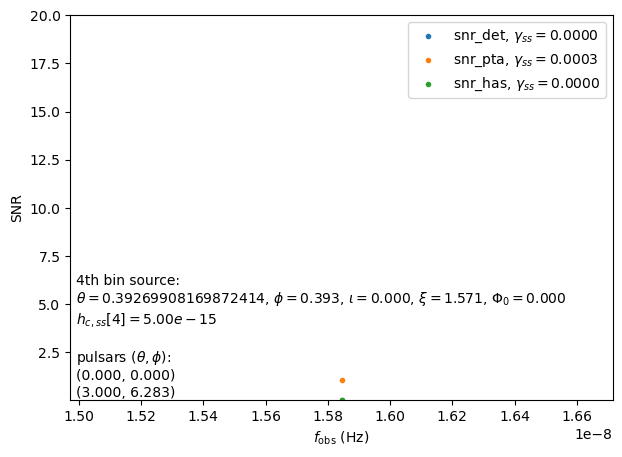

In [ ]:
dp_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())

plot_snr()


In [ ]:
# reset_ss()
hc_ss[ss,0,0] = 4*2.64e-15

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
[4.00192156e-05] (25, 1, 1) [0.         0.       

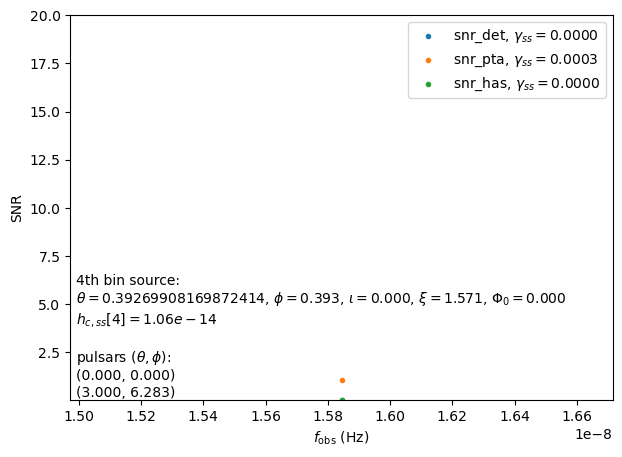

In [ ]:
dp_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())

plot_snr()


# Isolate inclination

gamma_ssi[0,0,0] is nan, setting to 0.
gamma_ssi[1,0,0] is nan, setting to 0.
gamma_ssi[2,0,0] is nan, setting to 0.
gamma_ssi[3,0,0] is nan, setting to 0.
gamma_ssi[5,0,0] is nan, setting to 0.
gamma_ssi[6,0,0] is nan, setting to 0.
gamma_ssi[7,0,0] is nan, setting to 0.
gamma_ssi[8,0,0] is nan, setting to 0.
gamma_ssi[9,0,0] is nan, setting to 0.
gamma_ssi[10,0,0] is nan, setting to 0.
gamma_ssi[11,0,0] is nan, setting to 0.
gamma_ssi[12,0,0] is nan, setting to 0.
gamma_ssi[13,0,0] is nan, setting to 0.
gamma_ssi[14,0,0] is nan, setting to 0.
gamma_ssi[15,0,0] is nan, setting to 0.
gamma_ssi[16,0,0] is nan, setting to 0.
gamma_ssi[17,0,0] is nan, setting to 0.
gamma_ssi[18,0,0] is nan, setting to 0.
gamma_ssi[19,0,0] is nan, setting to 0.
gamma_ssi[20,0,0] is nan, setting to 0.
gamma_ssi[21,0,0] is nan, setting to 0.
gamma_ssi[22,0,0] is nan, setting to 0.
gamma_ssi[23,0,0] is nan, setting to 0.
gamma_ssi[24,0,0] is nan, setting to 0.
[4.00192156e-05] (25, 1, 1) [0.0000000e+00 0.0000

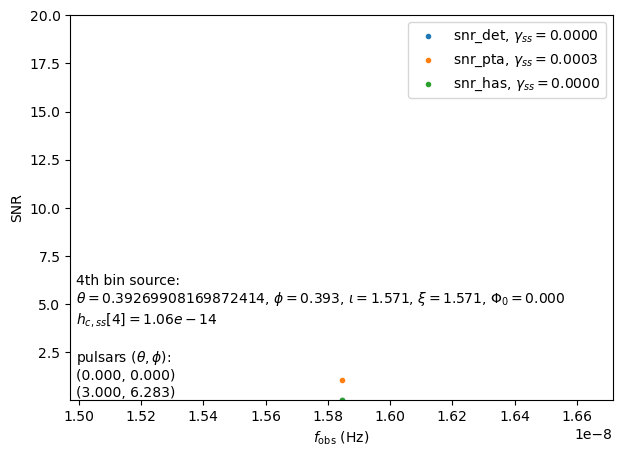

In [ ]:
reset_ss()
iota_ss[ss,0,0] = np.pi/2
p_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, psi_ss=psi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())

plot_snr()
